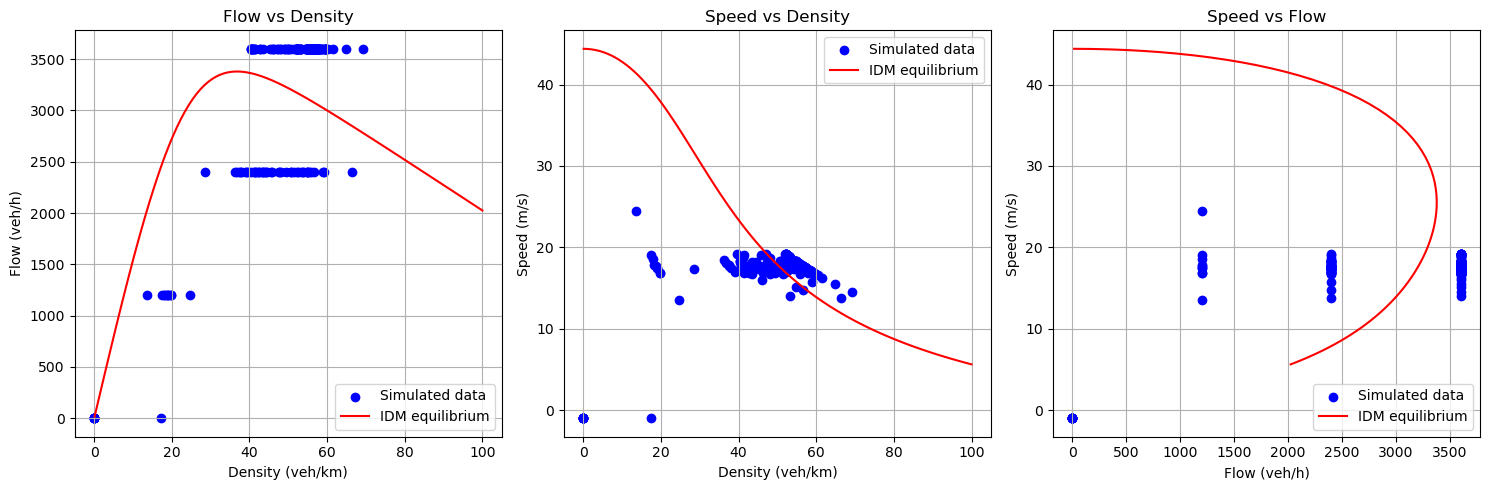

In [1]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from scipy.optimize import fsolve

# Parse the detector output file
tree = ET.parse('output_detector.out.xml')
root = tree.getroot()

# Extract data from each interval
flow = []      # vehicles per hour
speed = []     # m/s
occupancy = [] # percentage
for interval in root.findall('interval'):
    flow.append(float(interval.get('flow')))
    speed.append(float(interval.get('speed')))
    occupancy.append(float(interval.get('occupancy')))

# Calculate density from occupancy
average_vehicle_length = 4.5  # From vType length="4.5"
density = [occ / (100 * average_vehicle_length) for occ in occupancy]  # veh/m
density = [d * 1000 for d in density]  # Convert to veh/km

# Define equilibrium speed function for IDM
def equilibrium_speed(k, v0=44.4, s0=1, T=0.8, length=4.5, delta=4):
    """Calculate equilibrium speed v for a given density k."""
    if k <= 0:
        return v0  # Free flow speed when density is zero
    s_eq = 1000 / k - length  # Equilibrium gap in meters
    if s_eq <= s0:
        return 0  # Speed is zero if gap is less than minimum
    def func(v):
        return (v / v0)**delta + ((s0 + v * T) / s_eq)**2 - 1
    v_guess = v0 / 2  # Initial guess
    v_sol = fsolve(func, v_guess)[0]
    return max(v_sol, 0)  # Ensure non-negative speed

# Generate theoretical values for trend line
k_theory = np.linspace(0.1, 100, 100)  # Avoid k=0, range covers simulation data
v_eq = [equilibrium_speed(k) for k in k_theory]
q_eq = [k * v * 3.6 for k, v in zip(k_theory, v_eq)]  # Flow in veh/h

# Create the fundamental diagram plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Flow vs Density
ax1.scatter(density, flow, c='blue', label='Simulated data')
ax1.plot(k_theory, q_eq, 'r-', label='IDM equilibrium')
ax1.set_xlabel('Density (veh/km)')
ax1.set_ylabel('Flow (veh/h)')
ax1.set_title('Flow vs Density')
ax1.legend()
ax1.grid(True)

# Speed vs Density
ax2.scatter(density, speed, c='blue', label='Simulated data')
ax2.plot(k_theory, v_eq, 'r-', label='IDM equilibrium')
ax2.set_xlabel('Density (veh/km)')
ax2.set_ylabel('Speed (m/s)')
ax2.set_title('Speed vs Density')
ax2.legend()
ax2.grid(True)

# Flow vs Speed
ax3.scatter(flow, speed, c='blue', label='Simulated data')
ax3.plot( q_eq, v_eq,'r-', label='IDM equilibrium')
ax3.set_xlabel('Flow (veh/h)')
ax3.set_ylabel('Speed (m/s)')
ax3.set_title('Speed vs Flow')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.savefig('fundamental_diagram_with_trend.png', dpi=300)
plt.show()